# Reinforcement Learning: Deisigning AI to Play Atari Game

### Reinforcement Learning: 
Basic idea behind reinforcement learning is that an agent will learn from interacting with the environment and receiving rewards for performing actions. The purpose of reinforcement learning is to maximize cumulative rewards by taking suitable actions in a particular situation.

RL loop outputs a sequence of state, action and reward:
1. In state S0 from the environment
2. Takes an action A0
3. Transition to new state S1
4. Receives some rward R1

Gamma, the discount factor is used to discount rewards as the rewards that come sooner are more probable to happen than the long term future rewards. Therefore, gamma is used to penalize long term future rewards.

There are two types of tasks: episodic and continuous. I took the episodic approach for my project. Episodic tasks have a starting point and an ending point (a terminal state). Continuous tasks continue forever with no terminal state. 

There are two ways of learning: Monte Carlo and Temporal Difference (TD) Learning: 
1. Monte Carlo: cumulative rewards are received at the end of the game then calculate the maximum expected future reward
2. TD: estimates the reward at each step 

**Exploration/Exploitation trade off:**
- Exploration: finding more information about the environment
- Exploitation: exploiting known information to maximize the reward
- Exploitation will make the agent find the route to the largest cumulative rewards but will not know whether better route exists without exploration. 
- Epsilon: exploration rate

**Three Approaches to RL:** 
1. Value Based
2. Policy Based
3. Model Based: create a model of the behaviour of the environment

**Deep Reinforcement Learning:**
Deep neural networks to solve Reinforcement Learning Problems 
ie) Q-learning and Deep Q-learning


<img src="https://cdn-media-1.freecodecamp.org/images/1*w5GuxedZ9ivRYqM_MLUxOQ.png" width="400">

#### Q-learning
Q-learning is a value-based RL algorithm that is used to find the optimal action-selection policy using a Q function. 

Q(s,a) : action-value function that returns expected future reward of an action
In Q-learning, we build a memory table Q[s,a] to store Q-values for all possible combinations of s and a.

<img src="https://cdn-media-1.freecodecamp.org/images/1*QeoQEqWYYPs1P8yUwyaJVQ.png" width="200">

1. Initialize Q-values
2. Loop through number of episodes until learning is stopped
3. Choose an action (a) in the current state s --> implement exploration/exploitation trade-off
    a) From Q-table, determine action (a) with maximum Q
    b) sample an action 
4. Observe the outcome state (s') and reward (r) 
5. Update Q(s,a) table using function Q(s,a)

`New_Q = Current_Q + lr * [R + gamma* (highest Q of s') - Current_Q]`


#### Deep Q Network (DQN)
If the memory and the computation requirement for Q will be too high, switch to Deep Q Network to approximate Q(s,a). DQN takes a state then approximates Q-values for each action based on that state using neural network.

My Deep Q Neural Netook takes a stack of four frames as an input and these pass through the network outputing Q values for each possible action in the given state. 

**Preprocessing:**
- Grayscale as colour does not provide any important information, reduce three channels (RGB) to 1
- Reduce the size of the frame 
- Stack four frames together to catch motion 

**Convolution Networks:** 
- Processed by three convolution layers to exploit spatial relationships in images
- Each convolution layer will use Relu as an activation function
- One fully connected layer with Relu action function 
- One output layer: Q-values of each action

**Experience Replay**
- Avoid forgetting previous experiences and reduce correlations between experiences
- When sequential samples are given to neural netowrk, tends to forget the previous experiences as it overwrites with new experiences. To avoid this, create a replay buffer that stores experiences then sample a small batch to feed into neural network 


### Open AI 

- Gym is a toolkit for developing and comparing reinforcement learning algorithms 
- Has a collection of simulated environments where we can easily implement our RL algorithm 
- Examples: Classic (Cart-Pole); Atari (Tennis) 

### Code for DQN

In [49]:
import gym
import random
import math
import numpy as np
from collections import deque
from gym import wrappers

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras import backend as K

In [50]:
from skimage.color import rgb2gray
from skimage.transform import resize

Defining Parameter values

In [51]:
alpha = 0.01 # learning rate
alpha_decay = 0.01
gamma = 0.99 # Discount
epsilon = 1.0 # Exploration
epsilon_min = 0.1
epsilon_decay = 0.9999

batch_size = 32
n_episodes = 50_000
update_target_rate = 10_000
train_start = 10_000

Implemented to neural network model in **Mnih et al. 2015, 'Human-level control through deep reinforcement learning'**:

Neural network model design: 
1. Convolves 32 filters of 8 x 8 with stride 4
2. Convolves 64 filters of 4 x 4 with stride 2
3. Convolves 54 filters of 3 x 3 with stride 1
4. Fully connected layer of 512 rectifier units
5. Fully connected linear layer wih a single output for each validation


In [52]:
def build_model(state_shape, action_shape):
    # Function to build a neural network model
    model = Sequential()
    model.add(Conv2D(32, (8, 8), strides=(4, 4), activation='relu', input_shape=state_shape))
    model.add(Conv2D(64, (4, 4), strides=(2, 2), activation='relu'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(action_shape))
    model.compile(loss=huber_loss, optimizer=Adam(lr=alpha, decay=alpha_decay))
    model.summary()
    return model

A Neural Network is trained using the stochastic gradient descent optimization algorithm and weights are updated using the backpropagation of error algorithm.

**Huber Loss function**
Acts like the mean squared error when the error is small, but like the mean absolute error when the error is large 

In [53]:
def huber_loss(a, b, in_keras=True):
    error = a - b
    quadratic_term = error*error / 2
    linear_term = abs(error) - 1/2
    use_linear_term = (abs(error) > 1.0)
    if in_keras:
        # Keras won't let us multiply floats by booleans, so we explicitly cast the booleans to floats
        use_linear_term = K.cast(use_linear_term, 'float32')
    return use_linear_term * linear_term + (1-use_linear_term) * quadratic_term

Preprocessing Functions:

In [54]:
def preprocess_image(state):
    # Preprocessing frame 
    processed_observe = np.uint8(resize(rgb2gray(state), (84, 84), mode='constant') * 255)
    return processed_observe

def reshape_frames(frames, state_shape):
    # Reshaping frame 
    return frames.reshape(1, state_shape[0], state_shape[1], state_shape[2])

Other functions that will be constantly used for training 

In [55]:
def remember(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

def choose_action(state, epsilon):
    return env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(model.predict(state))

def get_epsilon(epsilon):
    return max(epsilon_min, epsilon*epsilon_decay)

def train_replay(batch_size, epsilon):
    x_batch, y_batch = [], []
    minibatch = random.sample(memory, min(len(memory), batch_size))

    for state, action, reward, next_state, done in minibatch:
        y_target = model.predict(state)
        y_target[0][action] = reward if done else reward + gamma * np.max(model.predict(next_state)[0])
        x_batch.append(state[0])
        y_batch.append(y_target[0])

    model.fit(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch), verbose=0)

Setting an enviroment and model

In [56]:
env = gym.make('Pong-v0')

render = True
load_model = False

# Environment settings
state_shape = (84, 84, 4)
action_shape = env.action_space.n

# Memory
memory = deque(maxlen=1_000_000)

# Build models
model = build_model(state_shape, action_shape)

# loads weights  
if load_model:
    model.load_weights("dqn12_model.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 9, 9, 64)          32832     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               1606144   
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 3078      
Total params: 1,687,206
Trainable params: 1,687,206
Non-trainable params: 0
_________________________________________________________________


DQN

In [ ]:
scores = deque(maxlen=100)
global_step = 0

for e in range(n_episodes):
    done = False
    step = 0
    score = 0
    imgs = list()

    state = env.reset()
    frame = preprocess_image(state)
    # 4 frames
    frames = reshape_frames(np.stack((frame, frame, frame, frame), axis=2), state_shape)

    while not done:
        if render:
            img = env.render(mode='rgb_array')
            imgs.append(img)
        global_step += 1
        step += 1

        action = choose_action(frames, epsilon)
        state, reward, done, _ = env.step(action)
        frame = reshape_frames(preprocess_image(state), (84, 84, 1))
        next_frames = np.append(frame, frames[:, :, :, :3], axis=3)

        remember(frames, action, reward, next_frames, done)

        frame = next_frames
        reward = np.clip(reward, -1., 1.)
        score += reward

        if done:
            print("episode:", e, "  score:", score, "  memory length:", len(memory), "  epsilon:", epsilon,
                  "  global_step:", global_step, "   step:", step)
            step = 0
            
    imgs= np.asarray(imgs)
    np.savez_compressed(f'./dqn12/dqn1_v2_Episode{e}', imgs)            

    train_replay(batch_size, epsilon)
    
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
    scores.append(score)
    mean_score = np.mean(scores)

saves model

In [ ]:
model.save('dqn12_model.h5')

### Display Outputs

In [57]:
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
def play_episode(loaded_arr):
    plt.figure(figsize = (20,10))
    img = plt.imshow(loaded_arr[0]) # only call this once
    plt.axis('off')

    for i in loaded_arr:
        img.set_data(i) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)

#### Episode 0

This is the first Pong Game my agent plays (green on is my agent). It is only making random motions that are irrelevant to the motion of the ball. For example, when the ball is moving down, my agent is moving up. 

**Score** 21: 0

In [75]:
# loads a npz file for episode 0
episode0 = np.load('./dqn1/dqn1_v2_Episode0.npz')['arr_0']

KeyboardInterrupt: 

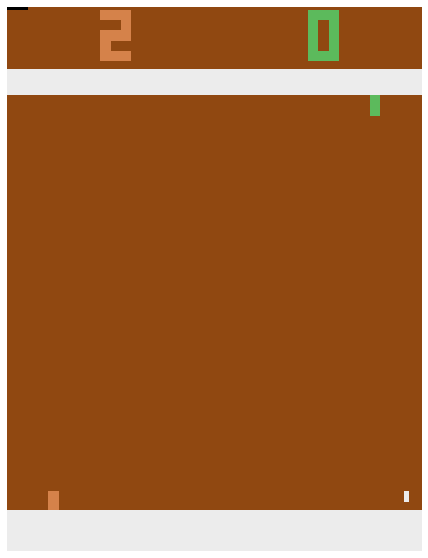

In [127]:
# plays frames saved for episode 0 in a loop 
play_episode(episode0)

#### Episode 510

After 510 games, my agent learned to be a better player. It learned to chase after a ball to get rewards (score a point) and also to hit the ball when it is nearby. The agent managed to score 6 points. 

**Score** 21: 6

In [76]:
episode_t = np.load('./dqn1/dqn1_v2_Episode510.npz')['arr_0']

KeyboardInterrupt: 

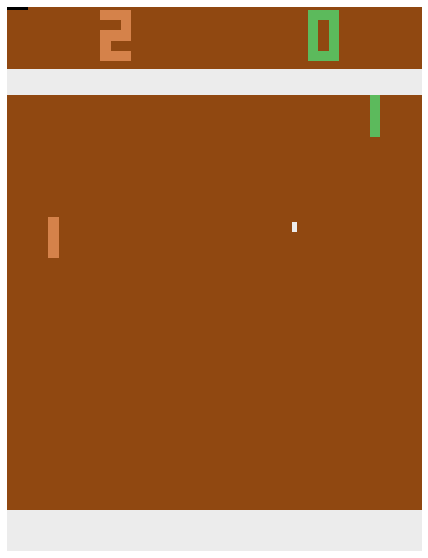

In [128]:
play_episode(episode_t)

### Conclusion 

With limits of computation power and time, the agent was not able to learn to win the game but learned to hit the ball and score 6 points. 

### Future areas of interest

1. Improve DQN Model 
    - Double DQN
    - Dueling Networks
    - Prioritized Experience Replay
    - Change Parameters (epsilon, epsilon decay, etc.) 


2. Research Different Approaches ie. A3C

3. Different applications to RL 
    - Traffic Light Control
    - Robotics/ Self-driving
    - Personalized Recommendations
    

### Resources

1. https://towardsdatascience.com/welcome-to-deep-reinforcement-learning-part-1-dqn-c3cab4d41b6b
2. https://towardsdatascience.com/simple-reinforcement-learning-q-learning-fcddc4b6fe56
3. https://www.analyticsvidhya.com/blog/2019/04/introduction-deep-q-learning-python/
4. https://www.freecodecamp.org/news/an-introduction-to-reinforcement-learning-4339519de419/